# Predicting Goal Success for the Maple Leafs
___

In [259]:
import psycopg2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn import svm, preprocessing, pipeline, set_config, compose, model_selection, ensemble

### Data Preparation
___

In [193]:
# create connection to database
connection = psycopg2.connect(
    host="localhost",
    database="50_in_07",
    user="tanyatang")

In [194]:
# select relevant data from database
cursor = connection.cursor()
cursor.execute(
    """
    WITH data AS (SELECT players.first_name
                       , players.last_name
                       , CONCAT(players.first_name, ' ', players.last_name) as full_name
                       , players.current_age
                       , players.height
                       , players.weight
                       , players.primary_position
                       , teams0.name AS opposing_team
                       , teams2.name AS away_team
                       , teams1.name AS home_team
                       , game_play_players.play_player_type
                       , game_plays.play_num
                       , game_plays.play_type
                       , game_plays.description
                       , game_plays.period_type
                       , game_plays.away_team_goals
                       , game_plays.home_team_goals
                       , game_plays.x_coordinate
                       , game_plays.y_coordinate
                    FROM players
                    JOIN game_play_players
                      ON players.id = game_play_players.player_id
                    JOIN game_plays
                      ON (game_play_players.game_id = game_plays.game_id
                          AND game_play_players.play_num = game_plays.play_num)
                    JOIN games
                      ON game_plays.game_id = games.id
                    JOIN teams AS teams0
                      ON (games.home_team_id + games.away_team_id - 10) = teams0.id
                    JOIN teams AS teams1
                      ON games.home_team_id = teams1.id
                    JOIN teams AS teams2
                      ON games.away_team_id = teams2.id)
          SELECT row_to_json(data.*)
            FROM data
    """)
results = cursor.fetchall()
cursor.close()

In [195]:
# close connection
connection.close()

In [213]:
# add ratio of leafs goals to total goals per play
all_data = list(map(lambda x: x[0], results))
goal_data = list(filter(lambda x: (x['play_type'] == 'Goal' or
                                  x['play_type'] == 'Shot' or
                                  x['play_type'] == 'Blocked Shot' or
                                  x['play_type'] == 'Missed Shot') and
                                  x['play_player_type'] != 'Goalie' and
                                  x['play_player_type'] != 'Unknown' and 
                                  x['play_player_type'] != 'Assist' and
                                  x['play_player_type'] != 'Blocker', all_data))
for play in goal_data:
    if play['opposing_team'] == play['home_team']:
        if play['home_team_goals'] == 0:
            play['goal_ratio'] = 1
        else:
            play['goal_ratio'] = play['away_team_goals'] / (play['home_team_goals'] + play['away_team_goals'])
    elif play['opposing_team'] == play['away_team']:
        if play['away_team_goals'] == 0:
            play['goal_ratio'] = 1
        else:
            play['goal_ratio'] = play['home_team_goals'] / (play['away_team_goals'] + play['home_team_goals'])
    else:
        print('Error')

In [214]:
# create pandas dataframe
goal_data = pd.json_normalize(goal_data)
print(goal_data.head(5))

  first_name last_name         full_name  current_age  height  weight  \
0    William  Nylander  William Nylander           24      72     196   
1    William  Nylander  William Nylander           24      72     196   
2   Mitchell    Marner   Mitchell Marner           23      72     175   
3    William  Nylander  William Nylander           24      72     196   
4    William  Nylander  William Nylander           24      72     196   

  primary_position   opposing_team            away_team       home_team  \
0       Right Wing  Buffalo Sabres  Toronto Maple Leafs  Buffalo Sabres   
1       Right Wing  Buffalo Sabres  Toronto Maple Leafs  Buffalo Sabres   
2       Right Wing  Buffalo Sabres  Toronto Maple Leafs  Buffalo Sabres   
3       Right Wing  Buffalo Sabres  Toronto Maple Leafs  Buffalo Sabres   
4       Right Wing  Buffalo Sabres  Toronto Maple Leafs  Buffalo Sabres   

  play_player_type  play_num     play_type  \
0           Scorer        24          Goal   
1          Shooter

### Data Visualization
___

In [180]:
# set maplotlib parameters
plt.style.use('seaborn-darkgrid')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.rcParams['figure.figsize'] = (10, 6)

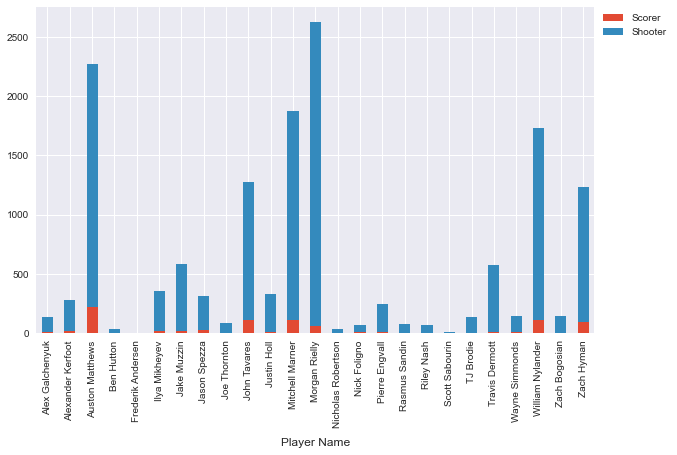

In [188]:
# plot distribution of unsuccesful shots and goals for players
goals_per_player = goal_data.groupby(['full_name', 'play_player_type'])['full_name']
ax = goals_per_player.count().unstack().plot(kind='bar', stacked=True)
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

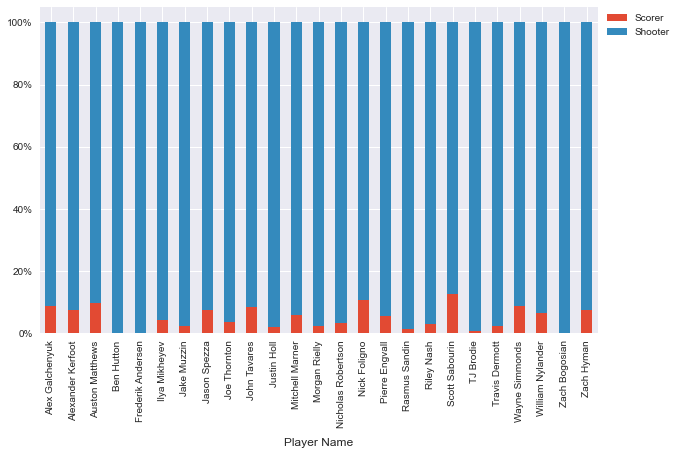

In [189]:
# plot normalized split between success and failure for each player
ax = goals_per_player.count().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar', stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('Player Name', labelpad=10)
ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.88))
plt.show()

### Data Preprocessing
___

In [247]:
# separate data into X and y sets
X = goal_data.loc[:, goal_data.columns != 'play_player_type']
y = goal_data['play_player_type']

In [248]:
# binarize classes
binarizer = preprocessing.LabelBinarizer()
binarizer.fit(['Scorer', 'Shooter'])
y = binarizer.transform(y)

In [249]:
# encode categorical features for full name, position, opposing team, and period type
# all data has been verified and cleaned before so there are no missing or unknown values
categorical_features = ['full_name', 'primary_position', 'opposing_team', 'period_type']
categorical_transformer = preprocessing.OneHotEncoder(handle_unknown='ignore')

In [250]:
# normalize numerical features for height, weight, x coordinate, y coordinate, goal ratio
# all data has been verified and cleaned before so there are no missing or unknown values
numerical_features = ['height', 'weight', 'x_coordinate', 'y_coordinate', 'goal_ratio']
numerical_transformer = StandardScaler()

In [251]:
# create column transformer that applies both numerical and categorical transformers
preprocessor = compose.ColumnTransformer(
    transformers = [
        ('categorical', categorical_transformer, categorical_features),
        ('numerical', numerical_transformer, numerical_features)
    ]
)

In [252]:
# split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.4, random_state=0
)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(
    X_test, y_test, test_size=0.6, random_state=0
)

### Support Vector Machine Classification
___

In [253]:
# create model
model_svm = svm.SVC(kernel='rbf', class_weight='balanced')

In [254]:
# create pipeline
pipeline_svm = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_svm)
])
set_config(display='diagram')
pipeline_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['full_name',
                                                   'primary_position',
                                                   'opposing_team',
                                                   'period_type']),
                                                 ('numerical', StandardScaler(),
                                                  ['height', 'weight',
                                                   'x_coordinate',
                                                   'y_coordinate',
                                                   'goal_ratio'])])),
                ('classifier', SVC(class_weight='balanced'))])

In [255]:
# train model


In [ ]:
# tune hyperparameters


In [ ]:
# classify test data and compare accuracy


### Random Forest Classification
___

In [261]:
# create model
model_rf = ensemble.RandomForestClassifier(max_depth=2, random_state=0)

In [262]:
# create pipeline
pipeline_rf = pipeline.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_rf)
])
set_config(display='diagram')
pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['full_name',
                                                   'primary_position',
                                                   'opposing_team',
                                                   'period_type']),
                                                 ('numerical', StandardScaler(),
                                                  ['height', 'weight',
                                                   'x_coordinate',
                                                   'y_coordinate',
                                                   'goal_ratio'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=2, random_state=0))])

In [ ]:
# train model


In [ ]:
# tune hyperparameters


In [ ]:
# classify test data and compare accuracy


### Results and Analysis
___

### Model Export
___